# <center><font color='brightgreen'>Анализ результатов маркетинговой компании банка с целью выявления потенциальных клиентов для открытия депозитного счета.</font>

Данный датасет представляет собой данные о маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. 
Наша задача состоит в анализе этих данных с целью выявления закономерностей и поиска решающих факторов, влияющих на то, что клиент вложит деньги именно в этот банк. Тем самым  мы сможем определять потенциальных клиентов для открытия депозита в этом банке и состредоточить рекламные и офферские ресурсы банка именно на этих клиентах.

Итак, <font color='brightorange'>**бизнес-задача:**</font>\
**определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.**

Итогом нашей работы должна стать <font color='brightorange'>**модель машинного обучения**</font>, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

Поставленная задача относится к задаче бинарной классификации, поэтому мы сравним несколько алгоритмов классификации и определим наилучший для решения нашей задачи.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd                                   # для анализа и обработки данных
import numpy as np                                    # для матричных вычислений
import matplotlib.pyplot as plt                       # для визуализации
import seaborn as sns                                 # для визуализиции

from sklearn import preprocessing                     # модуль с преобразованиями данных
from sklearn import feature_selection                 # модуль для выбора признаков/уменьшения размерности
from sklearn.model_selection import train_test_split  # сплитование датафрейма на выборки
from sklearn import metrics                           # модуль оценок качества алгоритмов
from sklearn.model_selection import cross_val_score   # функция среднего значения метрики при кросс-валидации

from sklearn import linear_model                      # модуль с алгоритмами регрессии
from sklearn import tree                              # модуль с алгоритмами решающего дерева
from sklearn import ensemble                          # модуль ансамблевых алгоритмов

from sklearn.model_selection import RandomizedSearchCV  # оптимизатор рандомного поиска гиперпараметров по сетке
import optuna                                         # фреймворк по подбору наилучших гиперпараметров

# !pip install catboost
from catboost import CatBoostClassifier               # фреймворк алгоритма градиентного бустинга

import warnings
warnings.filterwarnings('ignore')

###  <font color='brightgreen'>Этап 1. Знакомство с данными, обработка пропусков и выбросов
<a name="Знакомство с данными, обработка пропусков и выбросов"></a> 

Скачать данные можно по ссылке: https://drive.google.com/uc?id=1Fc0XeSyiweBTqOUuLZ-cz1XxjD3tV8Of

In [2]:
# загружаем данные
df = pd.read_csv('bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Факторы о клиентах банка:
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Факторы, относящиеся к текущей и прошлой маркетинговым кампаниям:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

Целевая переменная  - **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Её мы и будем предсказывать.

In [3]:
# посмотрим на размер датасета и типы данных
display(df.info())
null_count = df.isnull().sum()
print('Количество пропусков в данных: ', null_count[null_count>0], sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

Количество пропусков в данных: 
balance    25
dtype: int64


### <font color='blue'>1.1 Очистка признака *balance*</font>

Признак *balance* перед заполнением пропусков требует преобразование формата, так как он содержит неподходящий строковый формат с разделителями запятой и пробелом в числе, а также валютное обозначение $.

In [4]:
# выведем несколько значений признака, чтобы определить лишние знаки 
print(df['balance'].to_list()[:15])
# функция преобразования
def clean_balance(row):
    row = str(row).strip()                                         # метод удаляет пробелы в начале и в конце строки
    row = row.replace('$', '').replace(',', '.').replace(' ', '')  # удаляем все ненужные знаки и обозначения через метод замены 
    return float(row)                                              # возвращаем очищенное значение, преобразуя строку в число float
# применим функцию к столбцу balance
df['balance'] = df['balance'].apply(clean_balance)
# проверим наши преобразования
df['balance'].value_counts().iloc[:10]

[' 2 343,00 $ ', ' 45,00 $ ', ' 1 270,00 $ ', ' 2 476,00 $ ', ' 184,00 $ ', '0  $ ', ' 830,00 $ ', ' 545,00 $ ', ' 1,00 $ ', nan, ' 100,00 $ ', ' 309,00 $ ', ' 199,00 $ ', ' 460,00 $ ', ' 703,00 $ ']


0.0     774
1.0      39
3.0      34
2.0      34
4.0      29
5.0      27
19.0     20
8.0      19
62.0     18
6.0      17
Name: balance, dtype: int64

Теперь мы можем заполнить пропуски в признаке *balance*, для заполнения мы используем медианное значение данного признака.

In [5]:
df['balance'] = df['balance'].fillna(df['balance'].median())
# через метод isnull() убедимся, что пропусков больше нет
df['balance'].isnull().sum()

0

In [6]:
# выведем статистические показатели числовых признаков данных
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1526.936033,3224.829691,-6847.0,123.0,550.0,1699.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


Если мы посмотрим на статистические показатели числовых признаков, то обнаружим большой разброс в значениях между квартилями и минимальным-максимальным значениями прзнака *balance*, это однозначно указывает на большое количество выбросов.

Применим метод Тьюки для поиска и удаления выбросов из данных:\
по данному методу выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычитается полтора межквартильных размаха ($Q1 - 1.5 * IQR$) , а верхняя граница — как верхний квартиль, к которому прибавляется полтора межквартильных размаха ($Q3 + 1.5 * IQR$). 

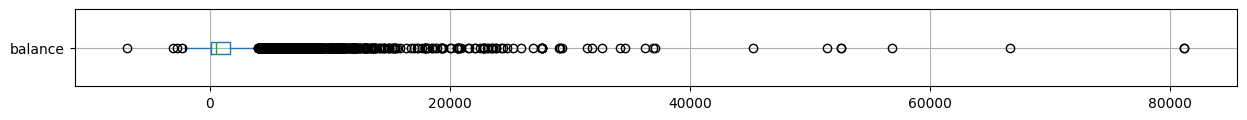

In [7]:
# посмотрим на коробчатой диаграмме количество выбросов
df[['balance']].boxplot(vert=False, figsize=(15,1))
plt.show()

In [8]:
print(f'Размер данных до удаления выбросов: {df.shape[0]}')

# функция нахождения выбросов по методу Тьюки
def find_outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False):
    """
    Находит выбросы в данных, используя метод межквартильного размаха. 
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством межквартильных размахов в обе стороны распределения
    Args:
        data (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов
        left (float, optional): количество межквартильных размахов в левую сторону распределения. По умолчанию 1.5.
        right (float, optional): количество межквартильных размахов в правую сторону распределения. По умолчанию 1.5.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# применим функцию к датасету
outliers, cleaned_df = find_outliers_iqr(df, 'balance')
print(f'Размер данных после удаления выбросов: {cleaned_df.shape[0]}')

Размер данных до удаления выбросов: 11162
Размер данных после удаления выбросов: 10105


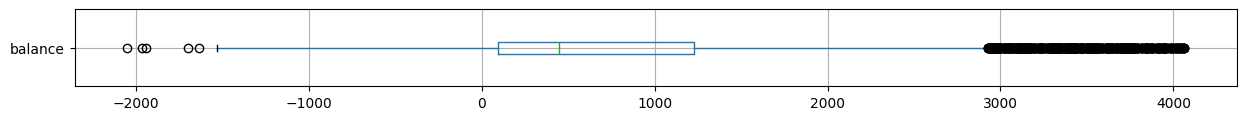

In [9]:
# посмотрим на преобразование признака balance после избавления от выбросов
cleaned_df[['balance']].boxplot(vert=False, figsize=(15,1))
plt.show()

### <font color='blue'>1.2 Подготовка признаков *job* и *education*</font>

Помимо явных пропусков в признаке *balance* есть пропуски в виде категориального значения 'unknown' в признаках *job* и *education*. Посмотрим на их количество.

In [10]:
print('Количество неизвествой категории в признаке сферы деятельности - unknown')
print(cleaned_df['job'].value_counts(ascending=True))
print('-'*10)
print('Количество неизвествой категории в признаке образования - unknown')
cleaned_df['education'].value_counts(ascending=True)

Количество неизвествой категории в признаке сферы деятельности - unknown
unknown            61
housemaid         252
entrepreneur      300
student           326
unemployed        332
self-employed     358
retired           663
services          868
admin.           1246
technician       1638
blue-collar      1807
management       2254
Name: job, dtype: int64
----------
Количество неизвествой категории в признаке образования - unknown


unknown       439
primary      1349
tertiary     3239
secondary    5078
Name: education, dtype: int64

Заменим значения *unknown* в признаках *job* и *education* на моды (самые популярные значения) данных признаков.

In [11]:
job_mode = cleaned_df['job'].mode()[0]                  # модальное значение признака job сферы деятельности
education_mode = cleaned_df['education'].mode()[0]      # модельное значение признака education образования
# с помощью метода replace() осуществим замену
cleaned_df['job'] = cleaned_df['job'].replace('unknown', job_mode)
cleaned_df['education'] = cleaned_df['education'].replace('unknown', education_mode)

### <font color='brightgreen'>Этап 2. Разведывательный анализ (Exploratory Data Analysis)</font>

### <font color='blue'>2.1 Представление целевого признака</font>

Прежде всего посмотрим на сбалансированность классов целевого признака, это очень важно для задач классификации.

Клиенты, открывшие депозитный счет - yes; клиенты, не имеющие депозитного счета - no
no     5424
yes    4681
Name: deposit, dtype: int64


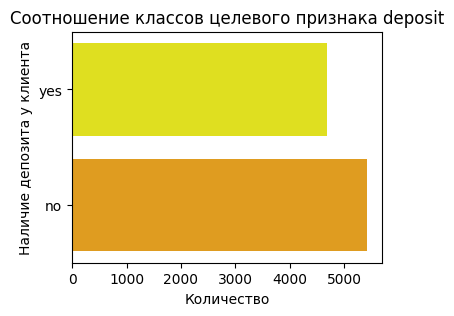

In [12]:
print('Клиенты, открывшие депозитный счет - yes; клиенты, не имеющие депозитного счета - no', cleaned_df['deposit'].value_counts(), sep='\n')
plt.figure(figsize=(4,3))
sns.countplot(cleaned_df['deposit'], palette=['yellow','orange'])
plt.title('Соотношение классов целевого признака deposit')
plt.xlabel('Количество')
plt.ylabel('Наличие депозита у клиента')
plt.show()

Классы можно назвать сбалансированными, не требуется сэмплирование (sampling).\
Клиентов, имеющих депозитный счет в банке меньше, поэтому банк правильно решил обратиться к аналитикам для выработки алгоритма по определению потенциальных клиентов для вложений в банк.

### <font color='blue'>2.2 Изучение числовых признаков в данных</font>

In [13]:
print('Статистические показатели числовых признаков')
cleaned_df.describe().T

Статистические показатели числовых признаков


,count,mean,std,min,25%,50%,75%,max
age,10105.0,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0
balance,10105.0,807.653538,994.151966,-2049.0,95.0,445.0,1227.0,4063.0
day,10105.0,15.590302,8.441510,1.0,8.0,15.0,22.0,31.0
duration,10105.0,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0
campaign,10105.0,2.517170,2.707159,1.0,1.0,2.0,3.0,43.0
pdays,10105.0,51.319644,109.644179,-1.0,-1.0,-1.0,2.0,854.0
previous,10105.0,0.816230,2.243795,0.0,0.0,0.0,1.0,58.0


Визуализируем числовые признаки в разрезе наличия или отсутствия депозита у клиента.

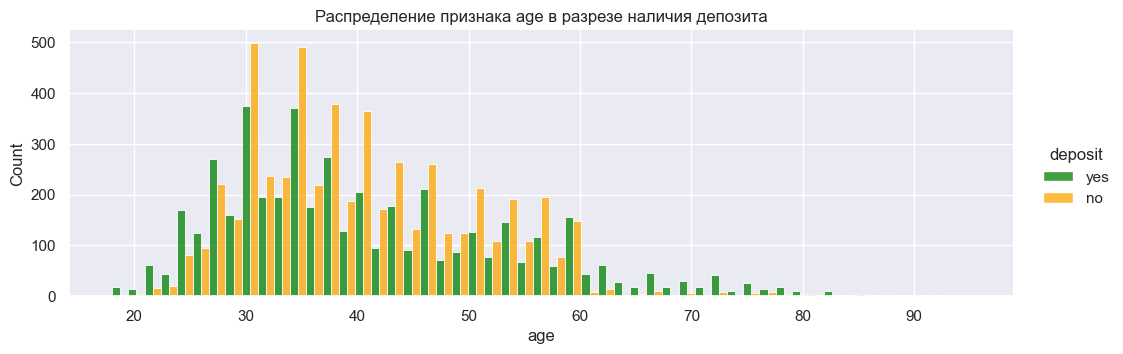

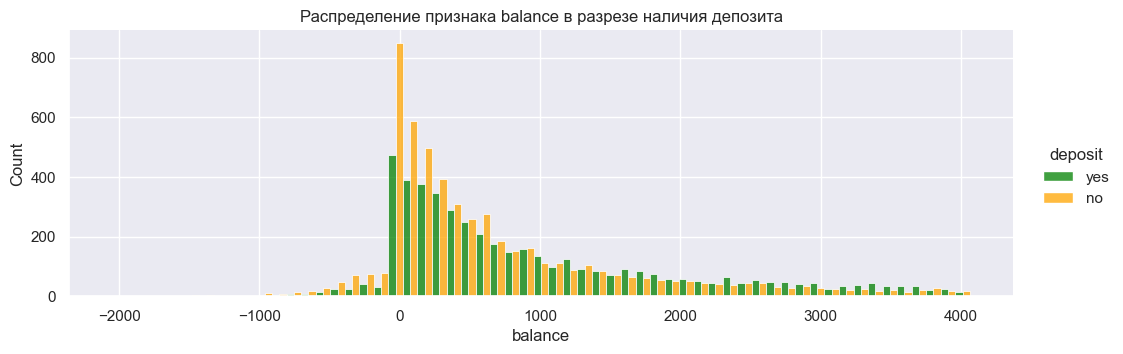

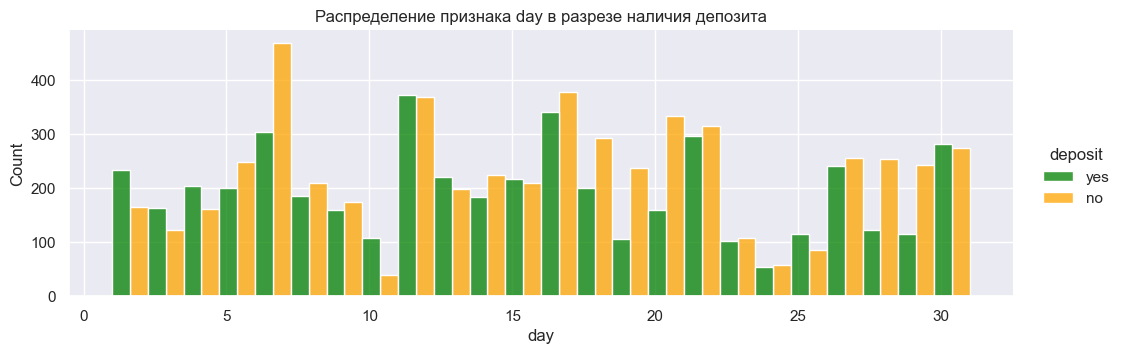

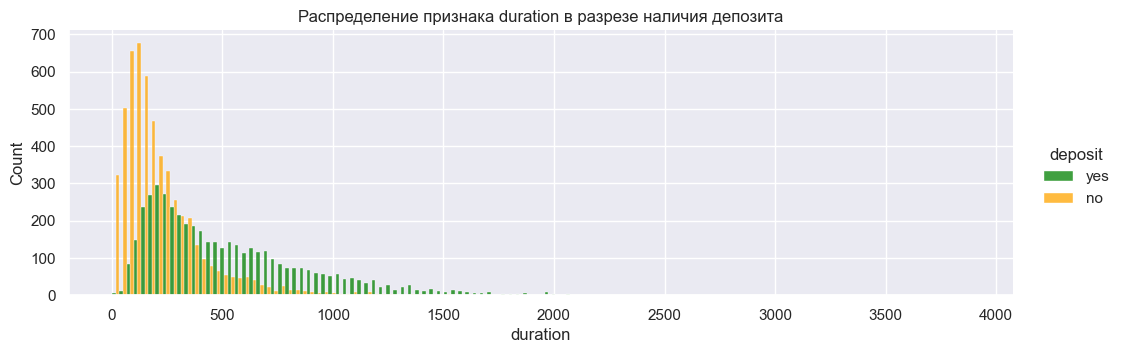

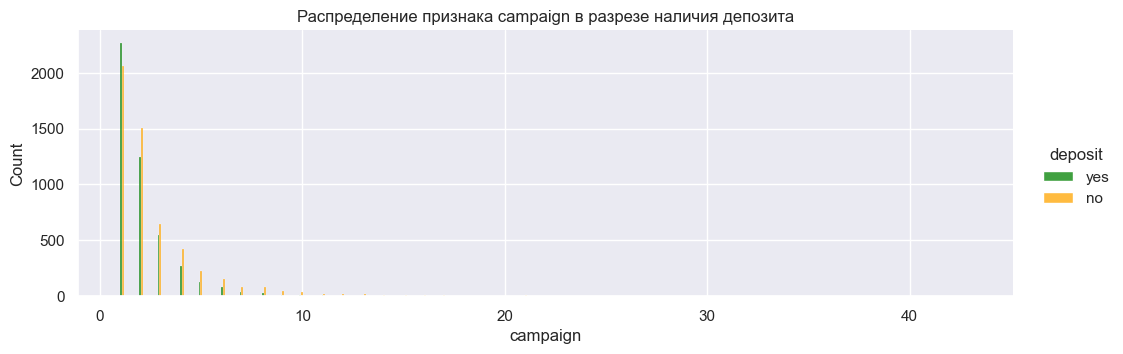

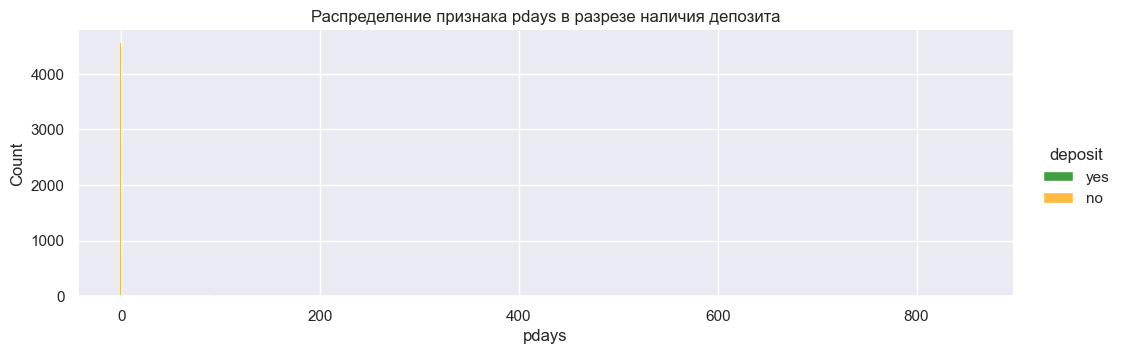

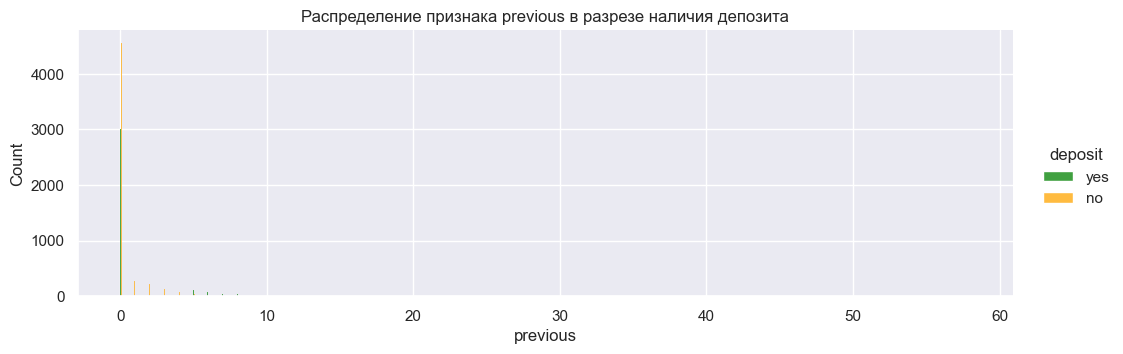

In [14]:
sns.set_theme(style="darkgrid")
# список числовых признаков
numeric_features = list(cleaned_df.select_dtypes(exclude=[object]).columns)
# в цикле по списку построим для каждого признака диаграмму
for feature in numeric_features:
    sns.displot(cleaned_df, x=feature, hue='deposit', palette=['green', 'orange'], multiple='dodge', kind='hist', height=3.5, aspect=3)
    plt.title(f'Распределение признака {feature} в разрезе наличия депозита')
plt.show()

**Какие предварительные выводы мы можем сделать:**
* К открытию депозитного счета стремятся молодые люди до 30 лет и старшее поколение за 60.
* Клиенты с балансом от 1500 $ скорее намерены иметь депозит, чем нет.
* Продолжительность разговора специалиста во время проведения маркетинговой компании влияет на положительное решение. Чем больше времени сотрудник уделил клиенту времени, тем больше шанс, что он откроет депозитный счет. В основном продолжительность разговора длится от 2.2 до 8.2 минут, а медина составила 4.2 минуты.
* Первый контакт во время маркетинговой компании наиболее важен, именно после первого разговора клиент принимает решение, а в последующих контактах мы видим, что меньше шансов убедить клиента. 
* Клиенты банка - это в основном люди в возрасте 32-48 лет.

### <font color='blue'>2.3 Изучение категориальных признаков в данных</font>

In [15]:
print('Статистические показатели категориальных признаков')
cleaned_df.describe(include='object').T

Статистические показатели категориальных признаков


,count,unique,top,freq
job,10105,11,management,2315
marital,10105,3,married,5715
education,10105,3,secondary,5517
default,10105,2,no,9939
housing,10105,2,no,5243
loan,10105,2,no,8712
contact,10105,3,cellular,7283
month,10105,12,may,2617
poutcome,10105,4,unknown,7570
deposit,10105,2,no,5424


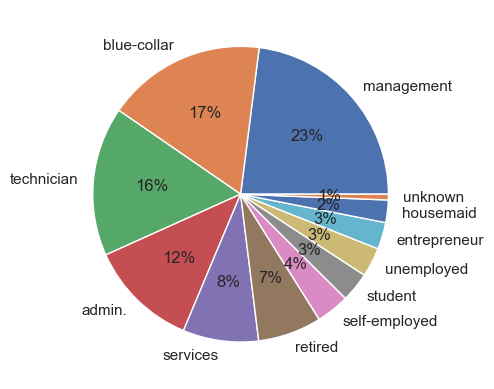

In [16]:
# соотношение категорий в признаке job сфера деятельности
value_job = df['job'].value_counts(normalize=True)*100
plt.pie(x=value_job.values, labels= value_job.index, autopct='%.0f%%')
plt.show()

Визуализируем на столбчатой диаграмме распределение всех категориальных признаков, а рядом эти же признаки в зависимости от целевого признака deposit

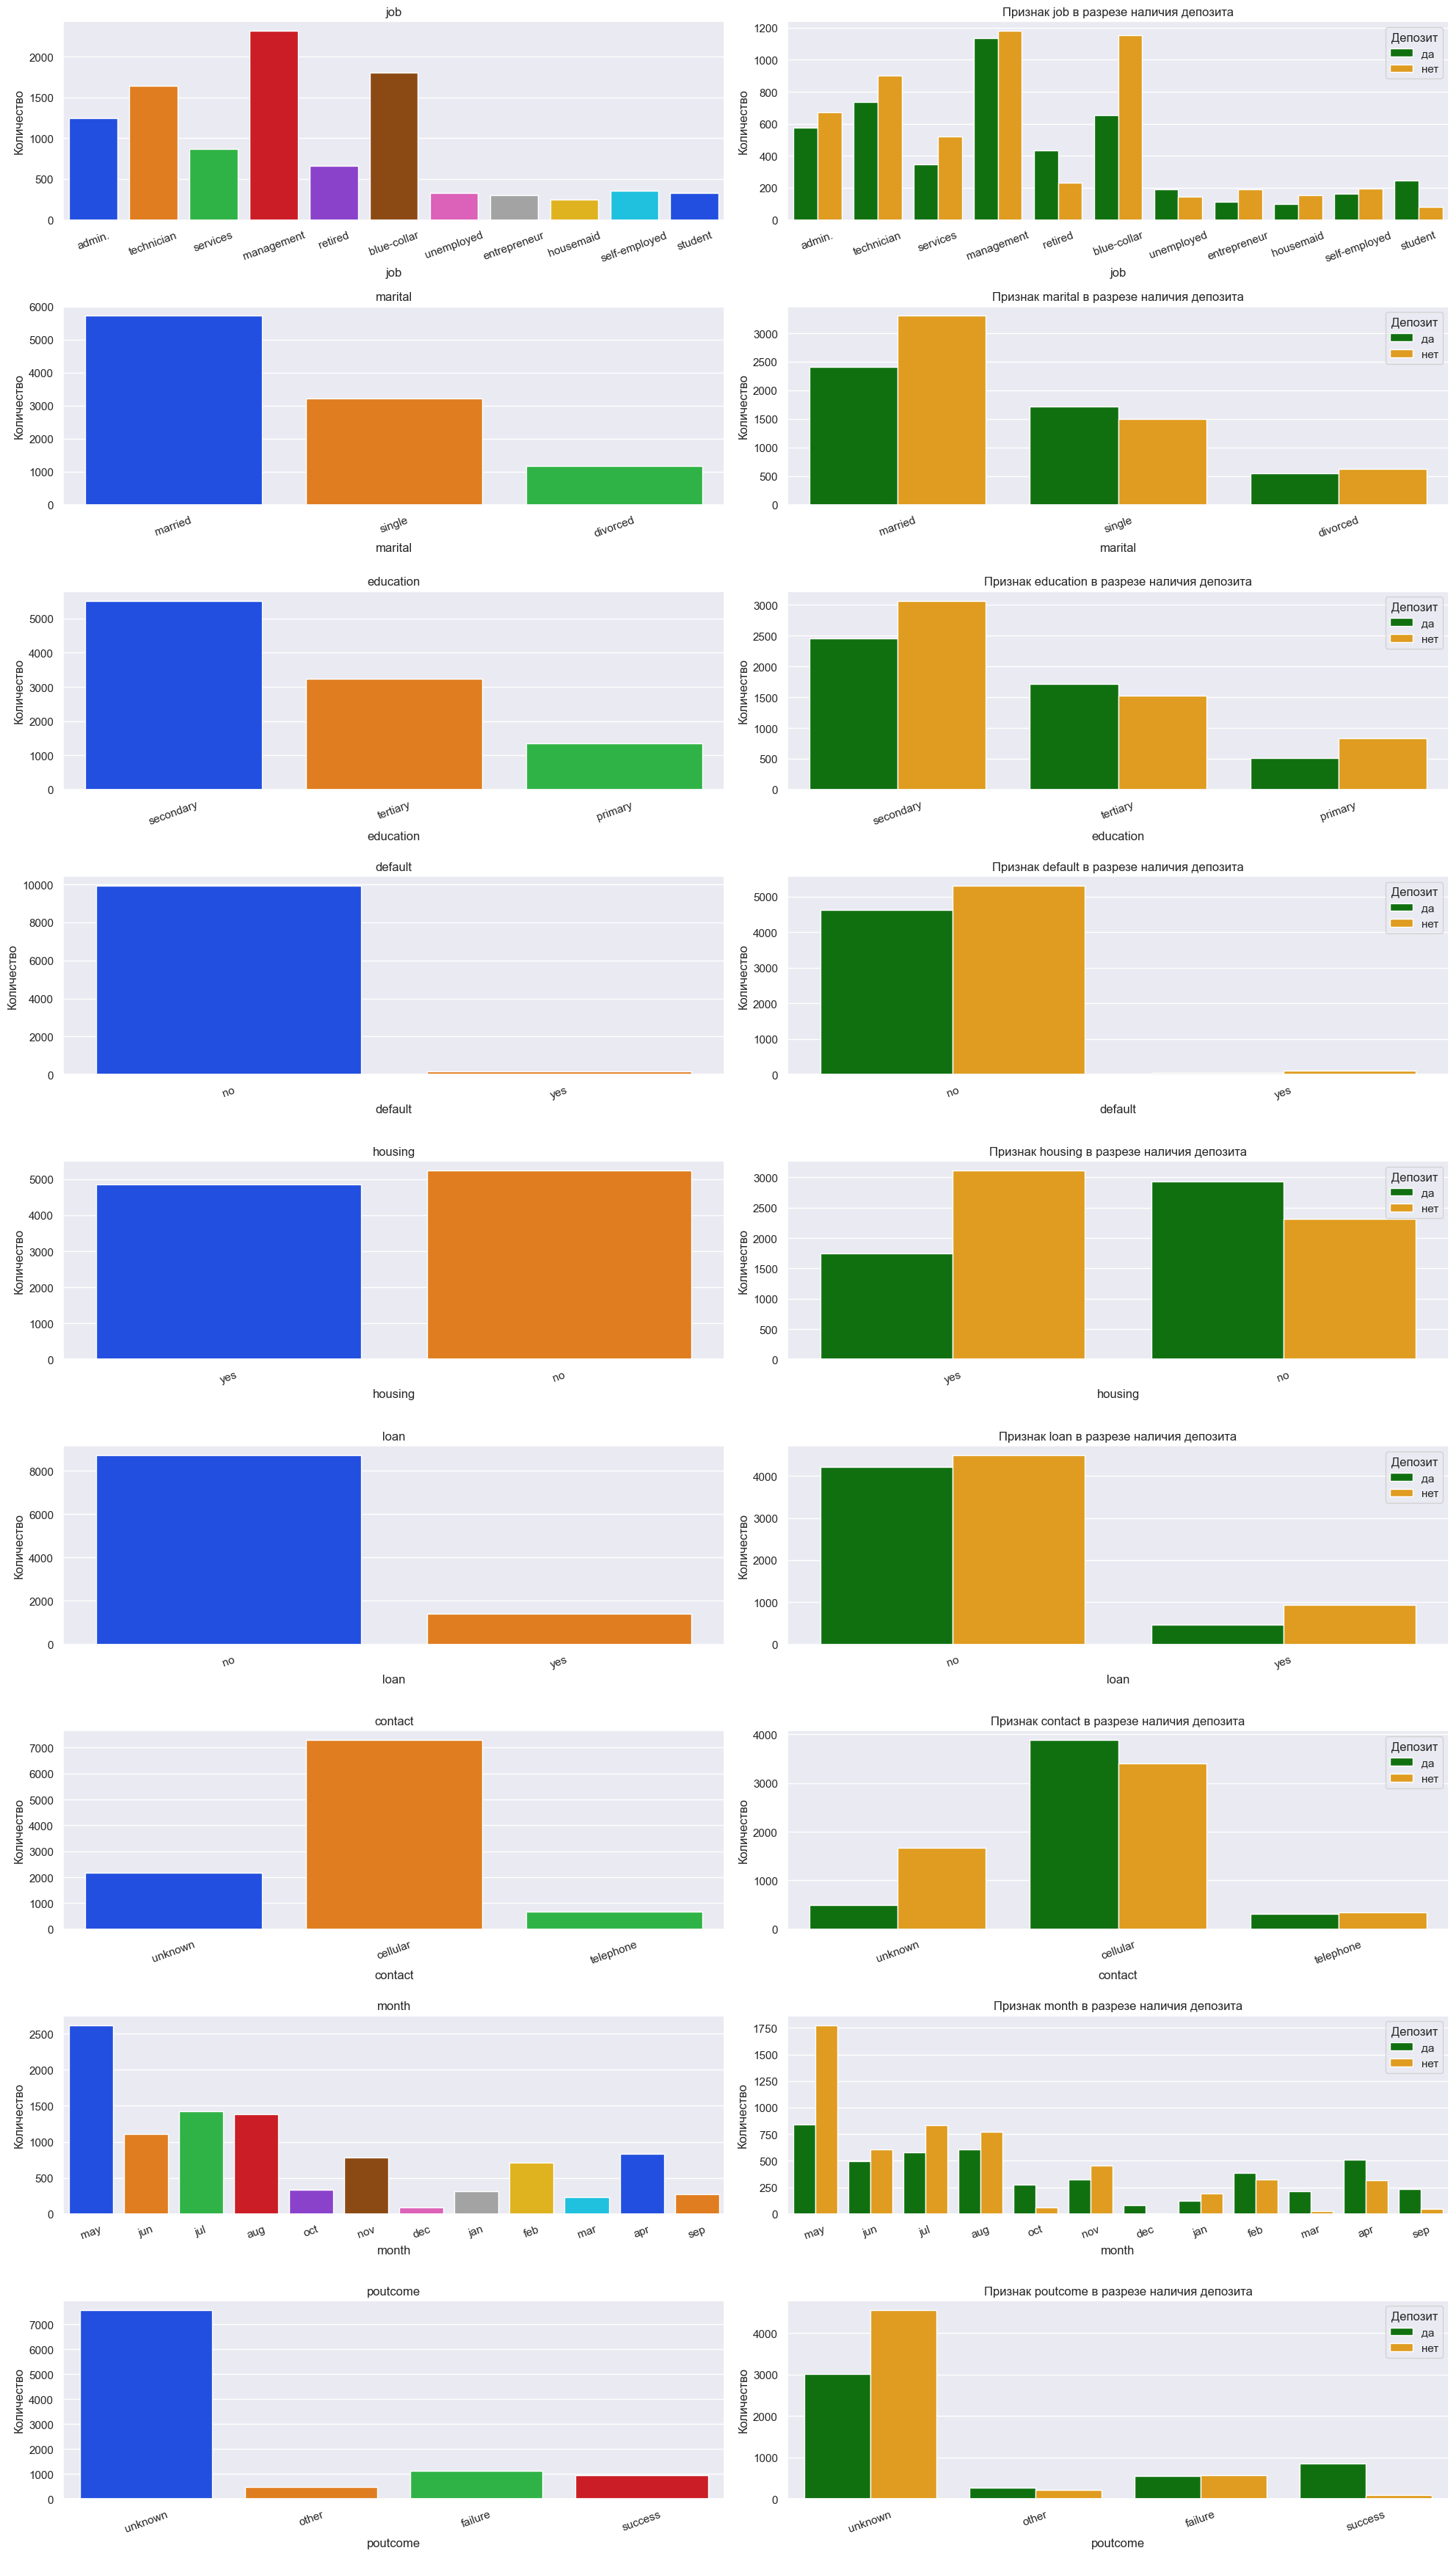

In [17]:
# список категориальных признаков
cat_features = list(cleaned_df.select_dtypes(include=[object]).columns)
cat_features.remove('deposit')
n = len(cat_features)
# создаем координатную плоскость
fig, axes = plt.subplots(n, 2, figsize=(20, 35))
# создаём цикл для всех признаков из списка
for i, feature in enumerate(cat_features):
    # строим количественную столбчатую диаграмму распределения признака
    countplot = sns.countplot(data=cleaned_df, x=feature, palette='bright', ax=axes[i][0])
    countplot.set_title(feature)    # название графика
    countplot.xaxis.set_tick_params(rotation=20)
    countplot.set_ylabel('Количество')
    # строим количественную столбчатую диаграмму того же признака в разрезе наличия или отсутствия депозита
    barplot = sns.countplot(data=cleaned_df, x=feature, hue='deposit', palette=['green', 'orange'], ax=axes[i][1])
    barplot.set_title(f'Признак {feature} в разрезе наличия депозита')   
    barplot.xaxis.set_tick_params(rotation=20)  
    barplot.set_ylabel('Количество')
    barplot.legend(title='Депозит', labels=['да', 'нет'])                                                          
plt.tight_layout()                                          # выравнивание графиков
plt.show()

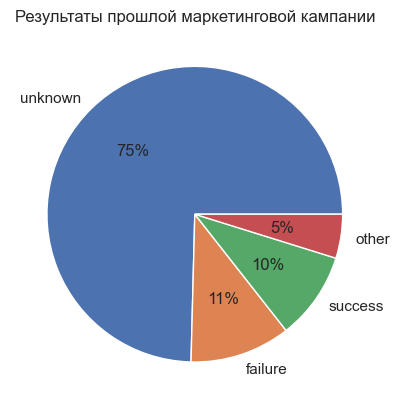

In [18]:
# посмотрим на соотношение результатов прошлой маркетинговой компании
value_poutcome = df['poutcome'].value_counts(normalize=True)*100
plt.pie(x=value_poutcome.values, labels= value_poutcome.index, autopct='%.0f%%')
plt.title('Результаты прошлой маркетинговой кампании')
plt.show()

**Наблюдения категориальных признаков выявили:**
* Студенты, безработные и пенсионеры легко открывают депозитные счета, что подтверждает наши предыдущие выводы, что к депозитам стремятся молодые люди и пенсионеры. Управленцы практически 50/50  - с депозитом и без, банку стоит сделать им выгодное предложение, так как почти 50% из них устраивает политика банка в отношении вкладов. И главное, что более 1/5 (23%) клиентов банка именно управленцы (люди с высоким доходом).
* Больше предпочитают открывать депозитные счета одинокие люди, а это обычно молодые люди и мы видели, что именно эта категория людей более склонна к открытию депозита.  Но более половины клиентов банка (56.5%) - это семейные люди, значит, банку необходимо придумать такие условия по депозитным вкладам, которые направленны именно на эту категорию.
* Уровень образования влияет на наличие депозита, люди с высшим образование более склонны иметь такой счет.
* Если ипотеки у клиента нет, то однозночно больше шансов, что он откроет депозитный счет. Но почти половина клиентов банка ~ 48% имеют ипотечные кредиты.
* Именно контакт по мобильному телефону и б`ольшая продолжительность разговора при проведении маркетинговой кампании поможет убедить клиента принять предложение банка и открыть депозит.
* Мы видим, что самым популярным месяцем для связи с клиентом был май и он же самым провальным, что говорит нам о плохом выборе месяца для проведения компании. Наиболее благоприятными месяцами для проведение маркетинговых компаний являются начало-середина весны: март, апрель, начало-середина осени: сентябрь, октябрь, окончание зимы: февраль. С конца весны и все лето, а также в январе лучше не загружать клиентов своими предложениями, они сейчас врядли ими заинтересуются, так как это время отдыха, летних развлечений, путешествий.
* Б`ольшую часть 75% результатов прошлой маркетинговой кампании составляет категория - неизвестно, это большой минус банку, если банк вкладывает большие ресурсы для проведения маркетинговой кампании, но в итоге не изучает детально результаты по итогам кампании, то в будущем ошибки прошлой маркетинговой кампании 'перетекут' в настоящую и улучшения не будет.

График визуализации показал нам, что признак *default* (информация о просроченном кредите) имеет практически одно значение.
Таким образом, он является неинформативным, можем его удалить.

In [19]:
print(cleaned_df['default'].value_counts(normalize=True)*100)
cleaned_df.drop('default', axis=1, inplace=True)

no     98.357249
yes     1.642751
Name: default, dtype: float64


In [20]:
# также убедимся, что датасет не содержит дубликатов перед дальнейшим преобразованием
mask = cleaned_df.duplicated(subset=list(cleaned_df.columns))
cleaned_df[mask].shape[0]

0

### <font color='blue'>2.4 Детальное изучение влияния различных признаков на наличие депозита у клиента, создание новых признаков</font>

##### **Преобразуем признак возвраста *age* в возрастные группы.**

Процентное соотношение по группам:
30-40    38.04
40-50    22.33
<30      18.51
50-60    16.09
60+       5.03
Name: age_groups, dtype: float64


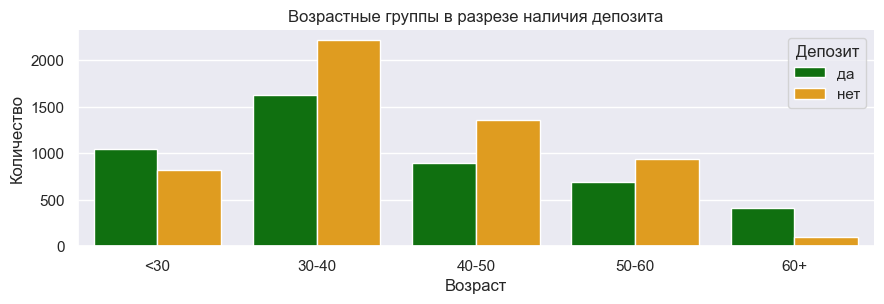

In [21]:
# создаем возрастные группы - категории
group_labels = ['<30', '30-40', '40-50', '50-60', '60+']
cut_bins = [0, 30, 40, 50, 60, 90]
# разделяем столбец age по возрастным группам
cleaned_df['age_groups'] = pd.cut(df['age'], bins=cut_bins, labels=group_labels)
print('Процентное соотношение по группам:', np.round(cleaned_df['age_groups'].value_counts(normalize=True)*100, 2), sep='\n')
# визуализируем на категориальном графике catplot созданные категории в разрезе наличия депозита
sns.catplot(cleaned_df, x='age_groups', hue='deposit', kind='count', palette=['green', 'orange'], height=3, aspect=3, legend_out=False)
plt.title('Возрастные группы в разрезе наличия депозита')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.legend(title='Депозит', labels=['да', 'нет'])
plt.show()

Предыдущие предположения о возврасте мы подвердили, достаточно легко соглашаются на открытие депозита молодые люди, это прежде всего студенты и безработные, которые как раз находятся на стадии поиска работы после получения образования, а также пенсионеры.\
Мы помним, что большинство клиентов банка - это люди в возрасте от 32 до 48 лет, значит, банку необходимо сосредоточится на маркетинге в отношении этих возрастов, так как среди них больше тех, кто не имеет депозита.

##### **Преобразуем признак баланса *balance* в категории.**

Процентное соотношение по категориям:
0-500        38.46
500-1000     17.75
<0           14.43
1500-2500    11.19
1000-1500     9.25
2500+         8.91
Name: balance_group, dtype: float64


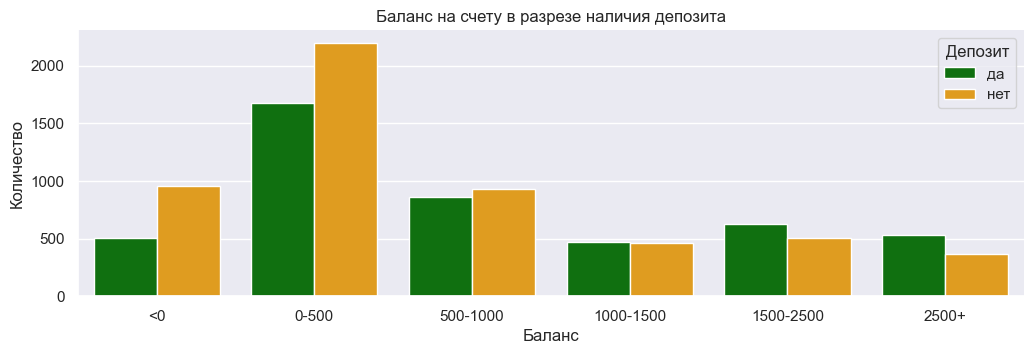

In [22]:
# создаем категории - разделение баланса по суммам
balance_labels = ['<0', '0-500', '500-1000', '1000-1500', '1500-2500', '2500+']
cut_bins = [-2049, 0, 500, 1000, 1500, 2500, 4000]
# разделяем столбец balance по категориям
cleaned_df['balance_group'] = pd.cut(df['balance'], bins=cut_bins, labels=balance_labels)
print('Процентное соотношение по категориям:', np.round(cleaned_df['balance_group'].value_counts(normalize=True)*100, 2), sep='\n')
sns.catplot(cleaned_df, x='balance_group', hue='deposit', kind='count', palette=['green', 'orange'], height=3.5, aspect=3, legend_out=False)
plt.title('Баланс на счету в разрезе наличия депозита')
plt.xlabel('Баланс')
plt.ylabel('Количество')
plt.legend(title='Депозит', labels=['да', 'нет'])
plt.show()

С балансом 1000-1500 $ половина клиентов открывают депозит, начиная с 1500 больше клиентов с наличием депозита, чем без него, то есть хороший доход влияет на открытие депозита, и мы видели, что пятую часть клиентов банка составляют управленцы с высоким доходом и половина из них еще не открыла депозит, однозначно, стоит сделать им убедительные предложения.\
Большую долю 38% составляют клиенты с небольшим балансом до 500 долларов, но скорее всего это перспективные клиенты, так как мы видели, что 38% клиентов в возрасте 30-40 лет и в дальнейшем их доход скорее всего будет расти и если все они уже сейчас откроют депозитные счета, то это будет плюсом для банка.

##### **Посмотрим как два фактора: семейное положение и уровень образования влияют на открытие депозита.**

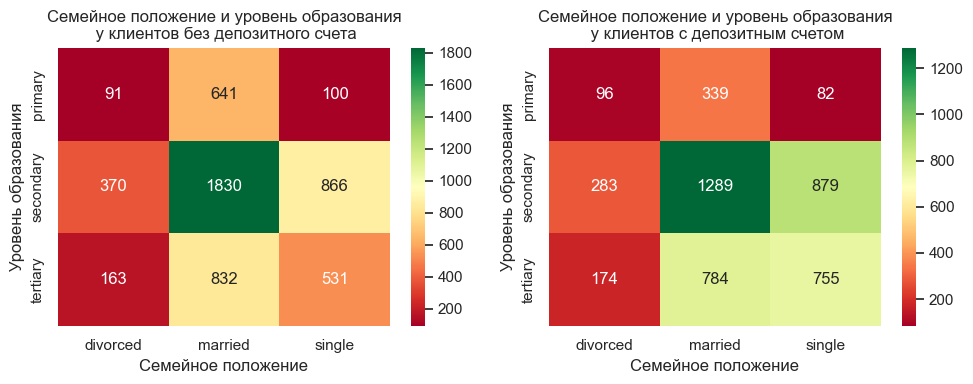

In [23]:
# создадим сводные таблицы, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны 
# в разрезе наличия депозитного счета
deposit_no = cleaned_df[cleaned_df.deposit =='no'].pivot_table(index='education', columns='marital', values='deposit', aggfunc='count')
deposit_yes = cleaned_df[cleaned_df.deposit =='yes'].pivot_table(index='education', columns='marital', values='deposit', aggfunc='count')
# отобразим таблицы на тепловых картах
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
pivot1 = sns.heatmap(deposit_no, annot=True, fmt='g', cmap='RdYlGn', ax=ax[0])
pivot1.set_title('Семейное положение и уровень образования\n у клиентов без депозитного счета')
pivot1.set_xlabel('Семейное положение')
pivot1.set_ylabel('Уровень образования')
pivot2 = sns.heatmap(deposit_yes, annot=True, fmt='g', cmap='RdYlGn', ax=ax[1])
pivot2.set_title('Семейное положение и уровень образования\n у клиентов c депозитным счетом')
pivot2.set_xlabel('Семейное положение')
pivot2.set_ylabel('Уровень образования')
plt.tight_layout()
plt.show()

Б`ольшую часть клиентов банка состаляют семейные люди:\
среди них больше людей без депозита и со средним специальным образование, на втором месте - с высшим;\
имеющие депозит - также в основном семейные люди со средним специальным образованием, на втором месте с высшим.\
Среди одиноких образованных людей клиентов с депозитным счетом больше, чем без депозита.

##### **Посмотрим еще на два фактора: сфера деятельности и размер баланса у клиента в разрезе наличия депозита.**

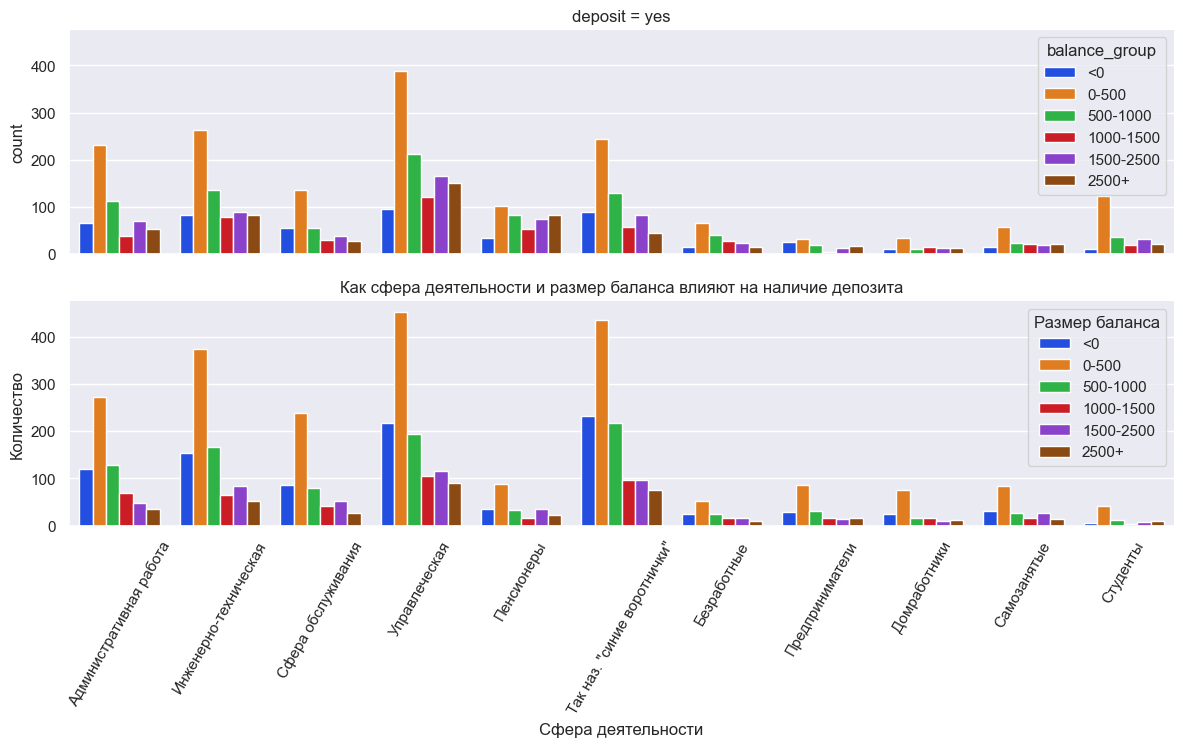

In [24]:
# строим количественную диаграмму распределения баланса по сферам деятельности в зависимости от наличия или нет депозита
sns.catplot(cleaned_df, x='job', row='deposit', hue='balance_group', kind='count', palette='bright', height=3, aspect=4, legend_out=False)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=['Административная работа', 'Инженерно-техническая', 'Сфера обслуживания', 
'Управлеческая', 'Пенсионеры', 'Так наз. "синие воротнички"', 'Безработные', 'Предприниматели', 'Домработники', 
'Самозанятые', 'Студенты'], rotation=60)
plt.xlabel('Сфера деятельности')
plt.ylabel('Количество')
plt.title('Как сфера деятельности и размер баланса влияют на наличие депозита')
plt.legend(title='Размер баланса')
plt.show()


Прежде всего подтверждаем, что много клиентов с небольшим балансом 0-500 долларов и наблюдаем это во всем сферах деятельности.\
У кого НЕТ депозита: чаще замечаем клиентов с отрицательным балансом, особенно в сфере "синих воротничков" и управленцев, что говорит нам: не все управленцы имеют в банке хороший баланс на счету.\
Также мы убедились, что у клиентов с балансом 1500-2500 и от 2500 долларов преобладет наличие депозита, нежели его отсутствие. 

###  <font color='brightgreen'>Этап 3. Кодирование, отбор и нормализация признаков</font>

### <font color='blue'>3.1 Кодирование признаков</font>

Наши категориальные факторы можно разделить на порядковые, номинальные, бинарные:
* порядковые - *education*, *age_groups* и *balance_group*,
* номинальные - *marital*, *job*, *contact*, *month*, *poutcome*,
* бинарные - *housing*, *loan*, целевой *deposit*.

В библиотеки sklearn за кодирования порядковых признаков отвечает класс OrdinalEncoder, который задает иерархию значениям.\
Номинальные признаки кодирует OneHotEncoder, а также аналогичный метод имеется в библиотеке pandas.get_dummies().\
Бинарное кодирование в данном датасете мы произведем заменой категорий yes/no на числовые категории 1/0.

In [25]:
# формируем списки категорий порядковых признаков
education = ['primary', 'secondary', 'tertiary']
age = ['<30', '30-40', '40-50', '50-60', '60+']
balance = ['<0', '0-500', '500-1000', '1000-1500', '1500-2500', '2500+']
# инициализируем класс OrdinalEncoder и в качестве параметра categories передаем списки для кодирования
encoder = preprocessing.OrdinalEncoder(categories=[education, age, balance], handle_unknown='use_encoded_value', unknown_value=-1)
cleaned_df[['education_enc', 'age_enc', 'balance_enc']] = encoder.fit_transform(
    cleaned_df[['education', 'age_groups', 'balance_group']]
)
print('Список признаков после порядкового кодирования: ', cleaned_df.columns, sep='\n')

Список признаков после порядкового кодирования: 
Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'deposit', 'age_groups', 'balance_group', 'education_enc',
       'age_enc', 'balance_enc'],
      dtype='object')


In [26]:
# проверим правильно ли закодировались порядковые признаки
print('Образование:', cleaned_df['education'].value_counts(), cleaned_df['education_enc'].value_counts(), sep='\n')
print('_'*10)
print('Возрастные группы:', cleaned_df['age_groups'].value_counts(), cleaned_df['age_groups'].value_counts(), sep='\n')
print('_'*10)
print('Размер баланса:', cleaned_df['balance_group'].value_counts(), cleaned_df['balance_group'].value_counts(), sep='\n')

Образование:
secondary    5517
tertiary     3239
primary      1349
Name: education, dtype: int64
1.0    5517
2.0    3239
0.0    1349
Name: education_enc, dtype: int64
__________
Возрастные группы:
30-40    3842
40-50    2255
<30      1870
50-60    1625
60+       508
Name: age_groups, dtype: int64
30-40    3842
40-50    2255
<30      1870
50-60    1625
60+       508
Name: age_groups, dtype: int64
__________
Размер баланса:
0-500        3878
500-1000     1790
<0           1455
1500-2500    1128
1000-1500     933
2500+         898
Name: balance_group, dtype: int64
0-500        3878
500-1000     1790
<0           1455
1500-2500    1128
1000-1500     933
2500+         898
Name: balance_group, dtype: int64


In [27]:
# так как порядковые признаки уже закодированы, удалим их исходные
cleaned_df.drop(['education', 'age_groups', 'balance_group'], axis=1, inplace=True)

Следующее кодирование:\
применим однократное кодирование номинальных признаков *job*, *marital*, *contact*, *month*, *poutcome* с помощью метода pandas.get_dummies().

In [28]:
cleaned_df = pd.get_dummies(cleaned_df, columns = ['job', 'marital', 'contact', 'month', 'poutcome'])

Осталось преобразовать бинарные признаки *deposit*, *housing*, *loan*:\
где значение 'yes' - укажем единицу 1, а значение 'no' заменим на нуль 0.

In [29]:
binary_col = ['deposit', 'housing', 'loan']
for col in binary_col:
    cleaned_df[col] = cleaned_df[col].apply(lambda x: 1 if x=='yes' else 0)
# посмотрим на итоговую таблицу
display(cleaned_df.head())
list(cleaned_df.columns)

,age,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343.0,1,0,5,1042,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
1,56,45.0,0,0,5,1467,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
2,41,1270.0,1,0,5,1389,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
3,55,2476.0,1,0,5,579,1,-1,0,1,...,0,0,1,0,0,0,0,0,0,1
4,54,184.0,0,0,5,673,2,-1,0,1,...,0,0,1,0,0,0,0,0,0,1


['age',
 'balance',
 'housing',
 'loan',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'deposit',
 'education_enc',
 'age_enc',
 'balance_enc',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown']

### <font color='blue'>3.2 Анализ мультиколлинеарности</font>

Очень важным этапом перед началом моделирования является анализ линейных связей между признаками, определение значимости, приступаем к отбору наиболее информативных факторов, по которым алгоритм классификации будет предсказывать целевую переменную.

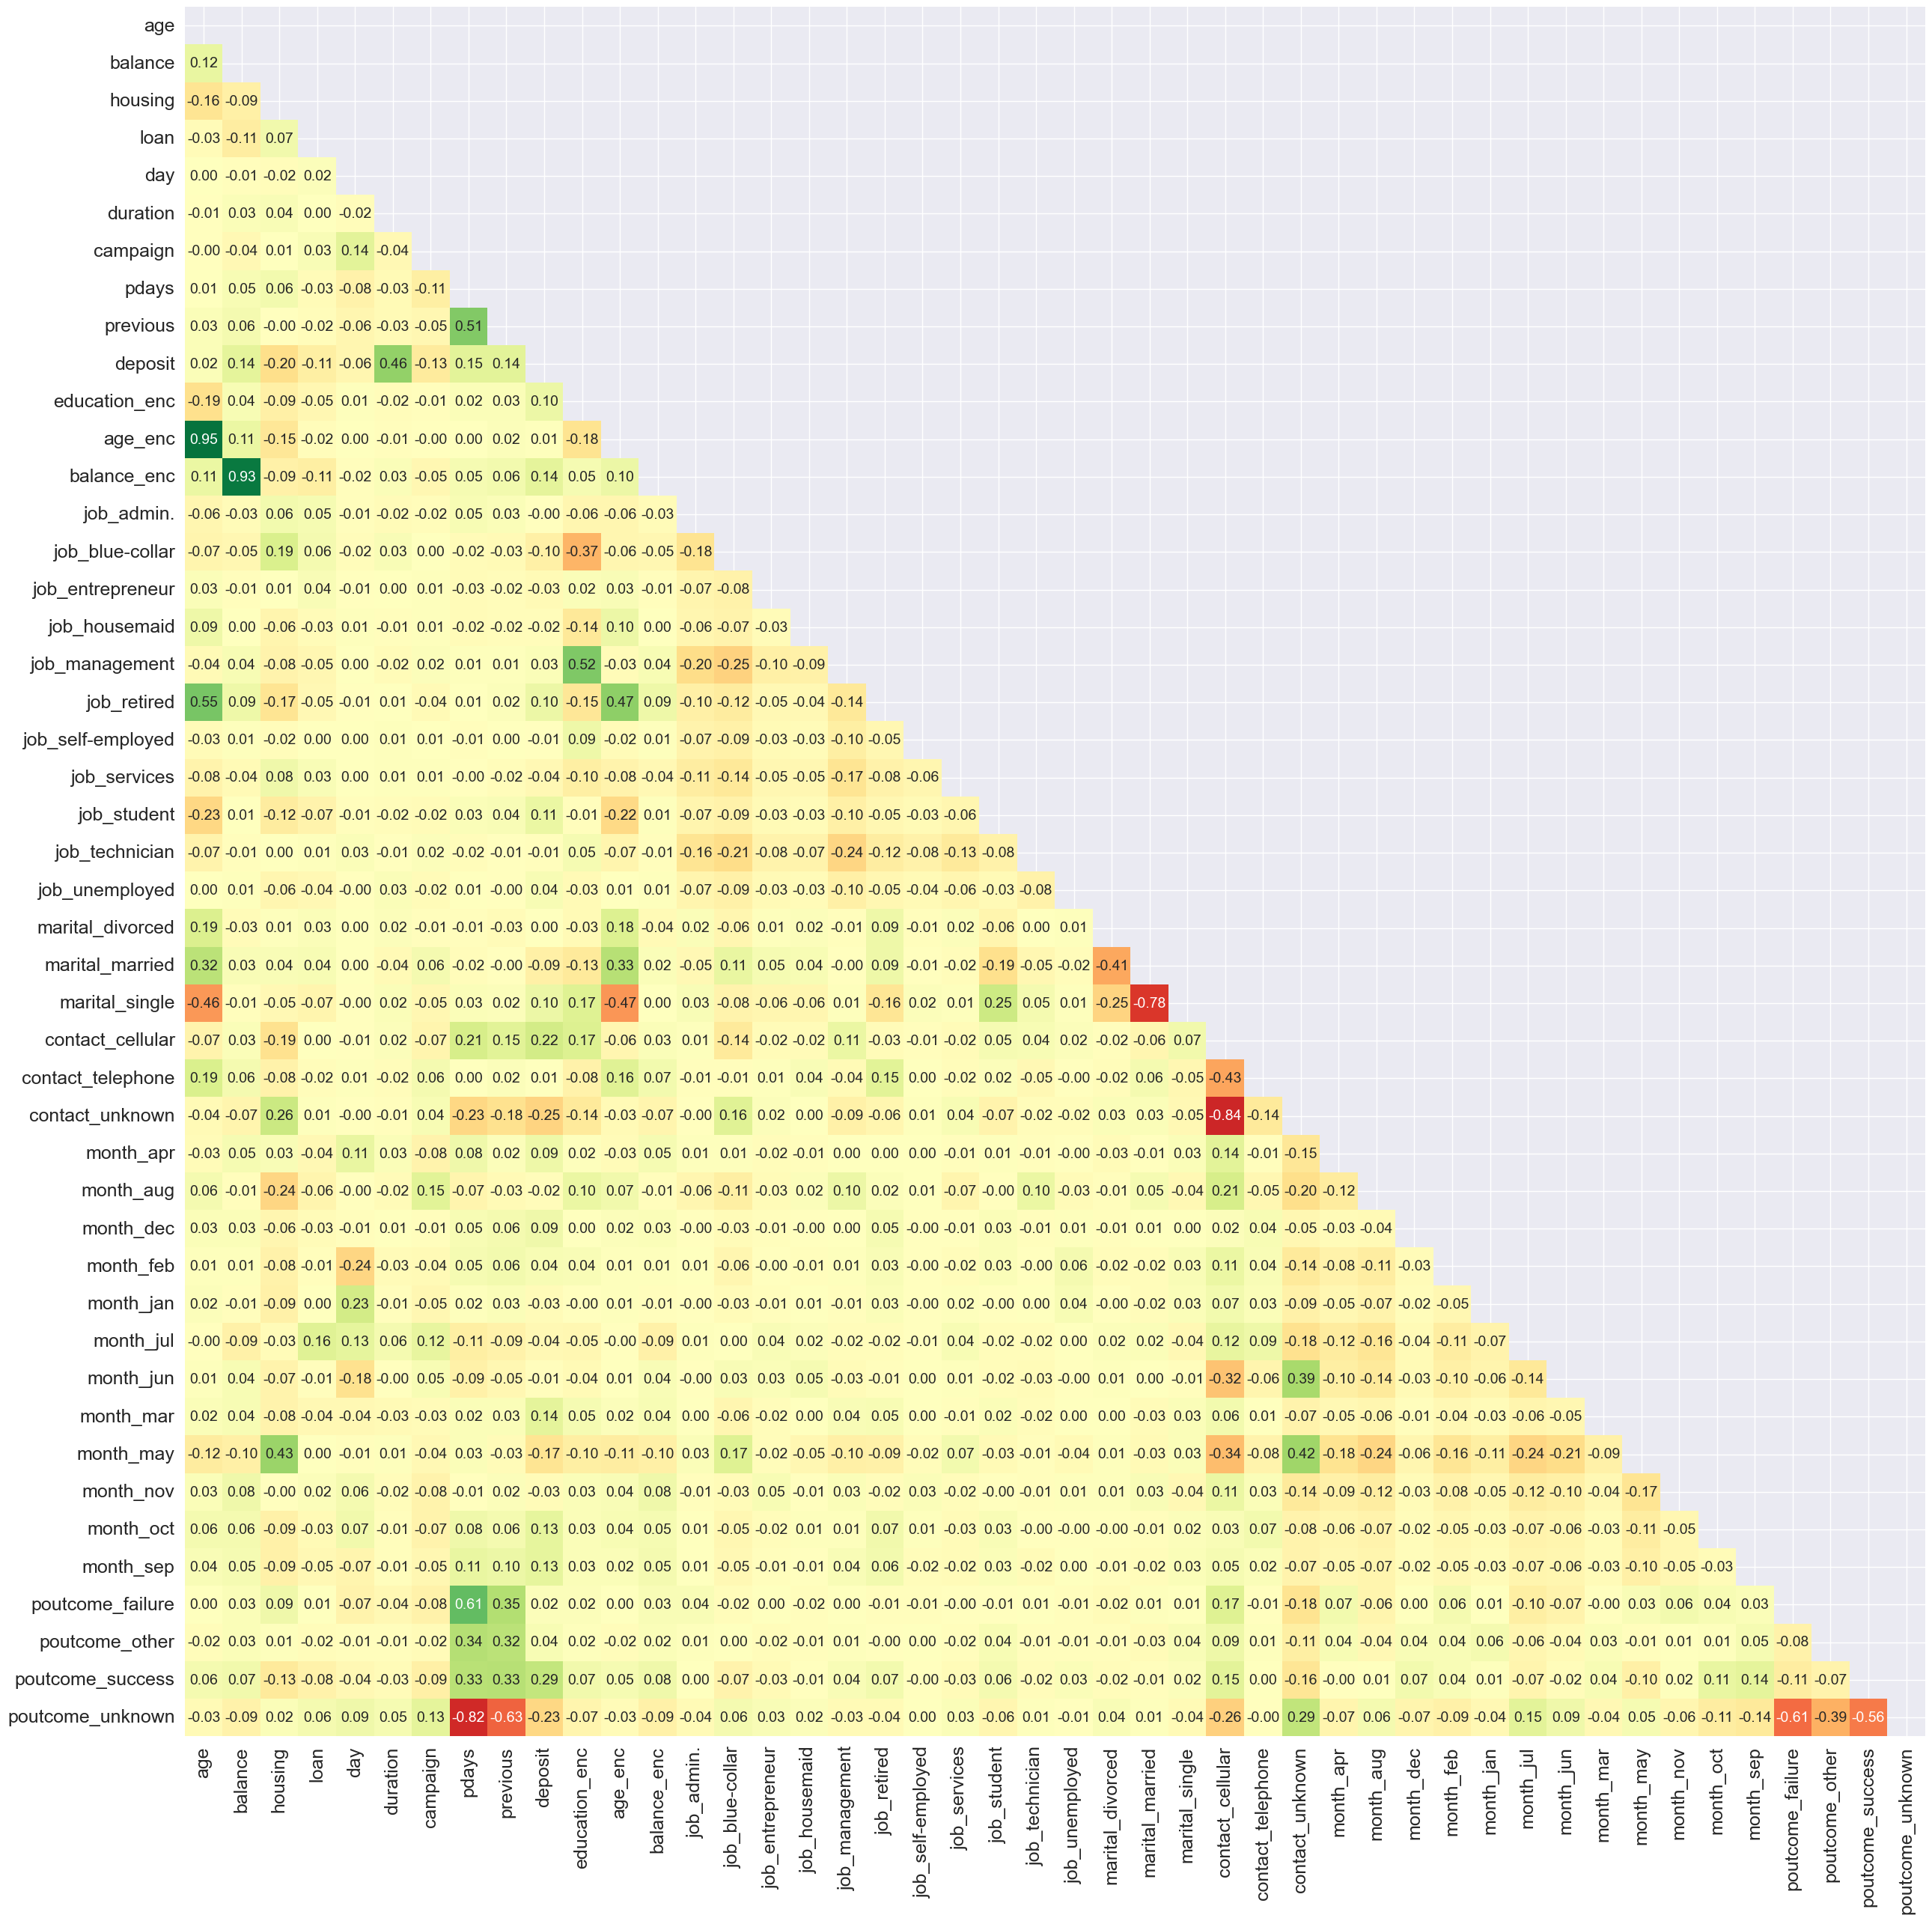

In [30]:
# построим корреляционную матрицу для оценки мультиколлинеарности
plt.figure(figsize=(30,30))
sns.heatmap(cleaned_df.corr(method='pearson'), cmap='RdYlGn', annot=True, fmt='.2f', annot_kws={"size": 14}, 
            mask=np.triu(cleaned_df.corr()), vmin=-1, vmax=1, center=0, cbar=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

Итак, критическую мультиколлинеарность мы наблюдаем между новыми признаками и исходными:
- age - age_enc (0.95),
- balance - balance_enc (0.93).

Сильная мультиколлинеарность присутствует:
- poutcome_unknown - pdays (-0.82).
- contact_unknown - contact_cellular (-0.84),
- marital_single - marital_married (-0.78).

Удалим признаки с критической мультиколлинеарностью: age_enc, balance_enc.

In [31]:
cleaned_df.drop(['age_enc', 'balance_enc'], axis=1, inplace=True)

Визуализируем корреляцию признаков с целевым и посмотрим на их степени влияния.

Степень корреляции с deposit: 
duration            0.457818
poutcome_success    0.288491
contact_unknown     0.249294
poutcome_unknown    0.228300
contact_cellular    0.223944
housing             0.200290
month_may           0.168203
pdays               0.147917
previous            0.141102
balance             0.135893
month_mar           0.135348
campaign            0.130707
month_oct           0.130599
month_sep           0.125239
loan                0.107240
job_student         0.105563
job_retired         0.100090
education_enc       0.098253
marital_single      0.097005
job_blue-collar     0.095845
Name: deposit, dtype: float64


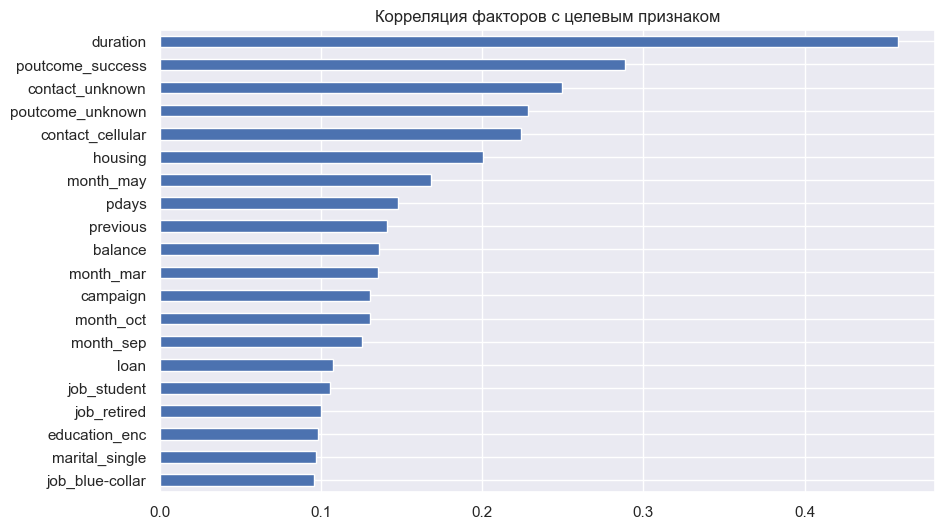

In [32]:
corr_target = cleaned_df.corr()['deposit']
# преобразуем значения корреляции в модуль значения
values = corr_target.sort_values().drop('deposit').apply(lambda x: abs(x))
# выведем топ-20 и отобразим их на столбчатой диаграмме
values = values.sort_values(ascending=False).iloc[0: 20]
print('Степень корреляции с deposit: ', values, sep='\n')
values.sort_values(ascending=True).plot.barh(figsize=(10,6))
plt.title('Корреляция факторов с целевым признаком', fontsize = 12)
plt.show()

Лидерами по линейным связям с целевой переменной являются:
* duration - продолжительность разговора с клиентом (0.46),
* poutcome_success - успешный результат прошлой маркетинговой кампании (0.29),
* contact_unknown - к сожалению, неизвестный способ связи с клиентов во время проведения маркетинговой компании (0.25),
* poutcome_unknown - неизвестный результат прошлой маркетинговой кампании (0.23), на что мы уже обращали внимание, что банк не подошел ответственно к подведению итогов предыдущей маркетинговой кампании,
* contact_cellular - связь с клиентами по мобильному телефону (0.22).

То есть наиболее важными факторами, влияющими на принятие решение об открытии депозитного счета, мы можем назвать:\
продолжительный контакт(скорее всего по мобильному телефону) с клиентом во время проведения кампании и успешное завершение маркетинговой компании.

### <font color='blue'>3.3 Тест на значимость, отбор признаков</font>

Произведем определение значимости с помощью метода SelectKBest из библиотеки sklearn, который отбирает k лучших функций на основе одномерных статистических тестов. Для задач классификации мы можем использовать дисперсионный анализ ANOVA - f_classif.

Дисперсионный анализ (ANOVA) — статистический метод, который используется для анализа различий между группами (факторами) и влияния различных факторов на исследуемую зависимую переменную. Он позволяет выявить, есть ли статистически значимое влияние одного или нескольких факторов на зависимую переменную, и определить, какие из факторов оказывают наибольшее влияние.

In [33]:
# выделим целевую переменную и матрицу наблюдений
X = cleaned_df.drop(['deposit'], axis=1)
y = cleaned_df['deposit']
# инициализируем объект класса SelectKDest, определим 20 наиболее значимых факторов
selector = feature_selection.SelectKBest(feature_selection.f_classif, k=20)
selector.fit(X, y)
opt_features = list(selector.get_feature_names_out())
opt_features

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'education_enc',
 'job_blue-collar',
 'job_retired',
 'job_student',
 'marital_single',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

То есть отбор с помощью дисперсионного анализа ANOVA показал идентичные результаты согласно корреляции по Пирсону.\
Оставим в нашем датасете для моделирования отобранные 20 факторов.

### <font color='blue'>3.4 Нормализация признаков</font>

Визуализация признаков показала нам, что числовые признаки не имеют нормального распределения, поэтому мы применим трансформацию.\
Используем Power Transformer. Он применяет степенные преобразования — параметрические, монотонные преобразования, которые применяются для придания данным сходства с Гауссом. Оптимальный параметр для стабилизации дисперсии и минимизации асимметрии оценивается через максимальное правдоподобие. Метод Yeo-Johnson поддерживает как положительные, так и отрицательные данные, его и используем.

Прежде, разделим наши данные на две выборки тренировочную и тестовую, применим при сплитовании стратификацию: равное деление целевой переменной на классы для обеих выборок.

In [34]:
# оставляем в датасете только отобранные 20 признаков
df = cleaned_df[opt_features+['deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print('Размер тренировочной выборки: ', X_train.shape, 'Размер тестовой выборки: ', X_test.shape, sep='\n')
print('Соотношение классов целевой переменной в тренировочной выборке: ', y_train.value_counts(normalize=True)*100,
      'Соотношение классов целевой переменной в тестовой выборке: ', y_test.value_counts(normalize=True)*100, sep='\n')

Размер тренировочной выборки: 
(6770, 20)
Размер тестовой выборки: 
(3335, 20)
Соотношение классов целевой переменной в тренировочной выборке: 
0    53.677991
1    46.322009
Name: deposit, dtype: float64
Соотношение классов целевой переменной в тестовой выборке: 
0    53.673163
1    46.326837
Name: deposit, dtype: float64


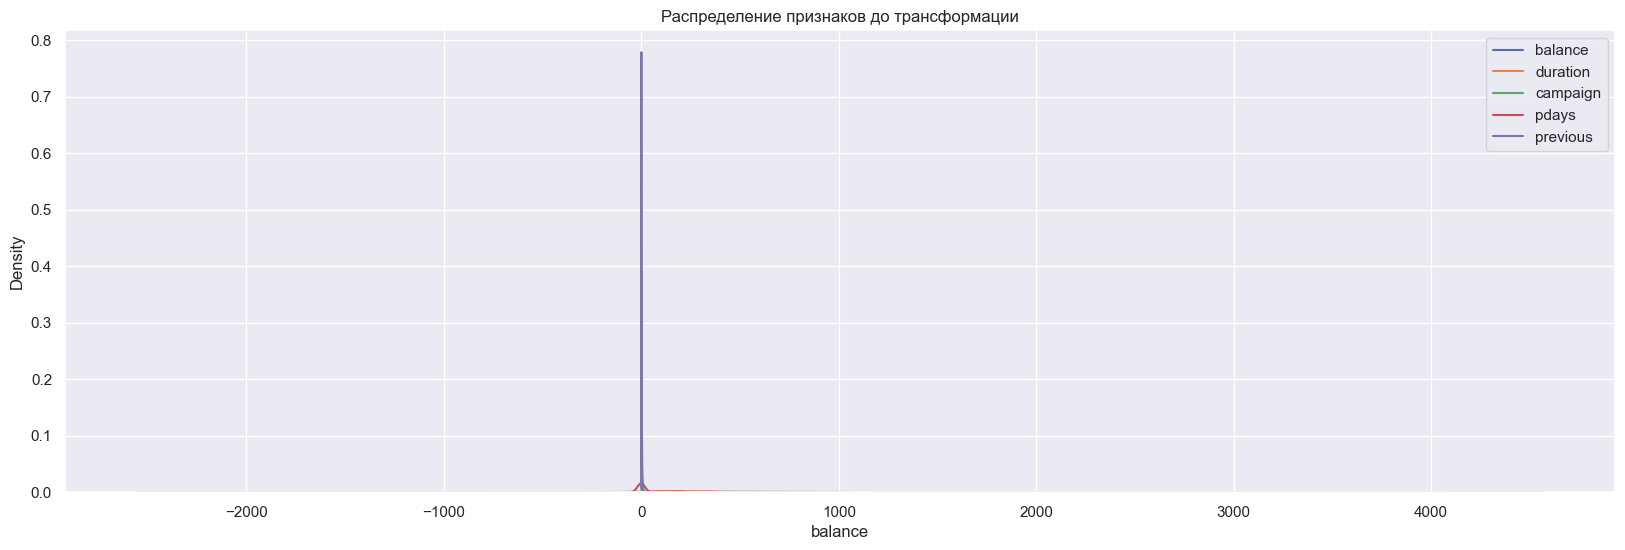

In [35]:
# визуализируем распределение числовых признаков до трансформации на специальном графике kdeplot() (KDE – оценка плотности ядра)
fig, ax = plt.subplots(ncols=1, figsize=(20, 6))
ax.set_title('Распределение признаков до трансформации')
sns.kdeplot(X_train['balance'], ax=ax, label ='balance')
sns.kdeplot(X_train['duration'], ax=ax, label ='duration')
sns.kdeplot(X_train['campaign'], ax=ax, label ='campaign')
sns.kdeplot(X_train['pdays'], ax=ax, label = 'pdays')
sns.kdeplot(X_train['previous'], ax=ax, label = 'previous')
plt.legend()
plt.show()

In [36]:
# инициализируем трансформер
transformer = preprocessing.PowerTransformer(method='yeo-johnson')
# трансформируем числовые факторы в обеих выборках
X_train[['balance', 'duration', 'campaign', 'pdays', 'previous']] = transformer.fit_transform(X_train[['balance', 'duration', 'campaign', 'pdays', 'previous']])
X_test[['balance', 'duration', 'campaign', 'pdays', 'previous']] = transformer.fit_transform(X_test[['balance', 'duration', 'campaign', 'pdays', 'previous']])

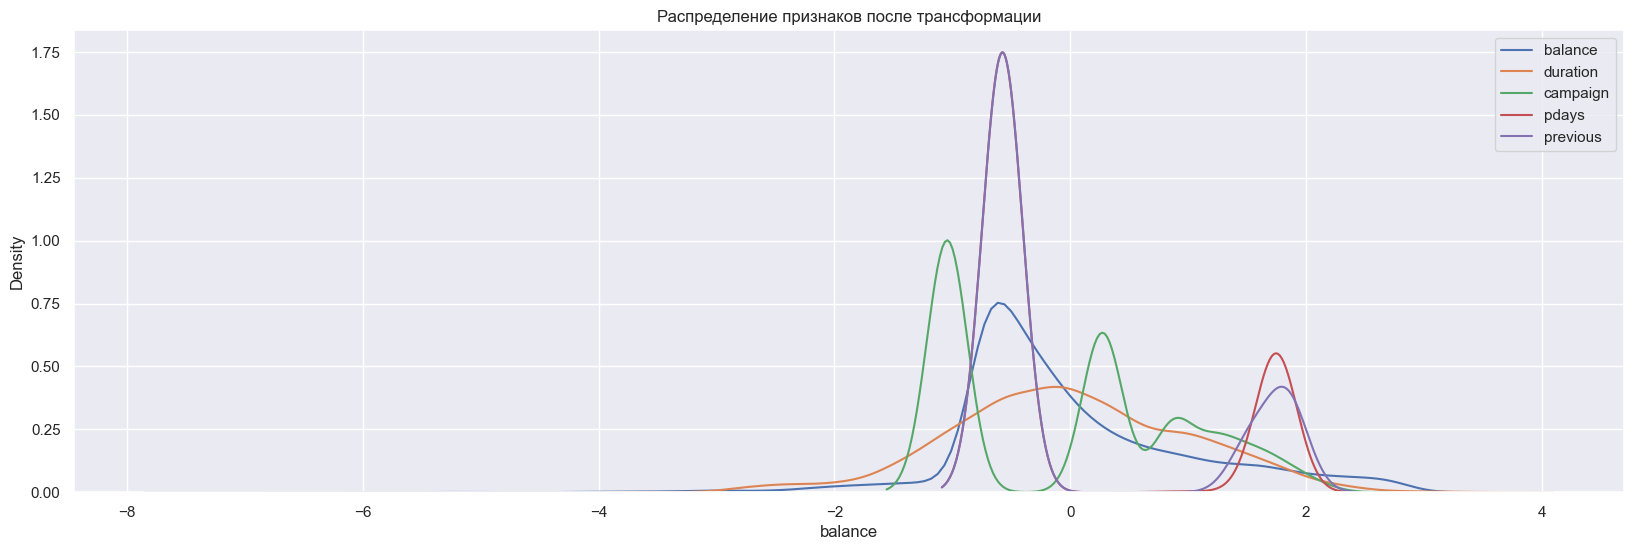

In [37]:
# визуализируем распределение числовых признаков после трансформации
fig, ax = plt.subplots(ncols=1, figsize=(20, 6))
ax.set_title('Распределение признаков после трансформации')
sns.kdeplot(X_train['balance'], ax=ax, label ='balance')
sns.kdeplot(X_train['duration'], ax=ax, label ='duration')
sns.kdeplot(X_train['campaign'], ax=ax, label ='campaign')
sns.kdeplot(X_train['pdays'], ax=ax, label = 'pdays')
sns.kdeplot(X_train['previous'], ax=ax, label = 'previous')
plt.legend()
plt.show()

###  <font color='brightgreen'>Этап 4. Создание простых моделей для решения задач классификации </font>

### <font color='blue'>4.1 Логистическая регрессия</font>

In [38]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_test = log_reg.predict(X_test)
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

F1-score на тестовой выборке для класса 0 и класса 1:  [0.827 0.799]
Accuracy test:  0.814


### <font color='blue'>4.2 Решающее дерево</font>

In [39]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
tree_model.fit(X_train, y_train)
y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)
print('F1-score на тренировочной выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_train, y_pred_train, average=None),3))
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

F1-score на тренировочной выборке для класса 0 и класса 1:  [1. 1.]
F1-score на тестовой выборке для класса 0 и класса 1:  [0.772 0.738]
Accuracy test:  0.756


Вторая модель - алгоритм решающего дерева показала нам хуже результат, так как произошло переобучение и она полностью подстроилась под тренировочную выборку.

Сделаем подбор наилучших гиперпараметров для обоих простых моделей и попробуем улучшить их качество.\
Мы будем осуществлять поиск гиперпараметров с помощью фреймворка Optuna, он эффективен и намного быстрее стандартных оптимизаторов sklearn как GridSearchCV и RandomizedSearchCV. Для сравнения в некоторых случаях будем испльзовать RamdomizedSearchCV.

**4.1.1 Подбор гиперпараметров для логистической регрессии на первом пространстве.**

In [40]:
# функция с алгоритмами оптимизации liblinear и saga для логистической регрессии
def optuna_log_1(trial):
    # задаем пространствo поиска гиперпараметров
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.1, 1, step=0.1)
  
    # создаем модель
    model_optuna_log_1 = linear_model.LogisticRegression(solver=solver, penalty=penalty, C=C, random_state=42)
    
    # получим значение метрики с помощью кросс-валидации
    score = cross_val_score(model_optuna_log_1, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

In [41]:
%%time
# cоздаем объект исследования логистической регрессии для первого набора гиперпараметров
# максимизируем метрику f1 direction='maximize'
study_log_1 = optuna.create_study(study_name='LogisticRegression', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз из пространства функции optuna_log_1
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_log_1.optimize(optuna_log_1, n_trials=30)

# выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study_log_1.best_params))
print('F1_score на тренировочной выборке: {:.3f}'.format(study_log_1.best_value))

[I 2024-03-28 14:49:21,918] A new study created in memory with name: LogisticRegression


Наилучшие значения гиперпараметров {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.7000000000000001}
F1_score на тренировочной выборке: 0.812
CPU times: total: 516 ms
Wall time: 4.58 s


**4.1.2 Подбор гиперпараметров для логистической регрессии на втором пространстве.**

In [42]:
# функция с алгоритмами оптимизации lbfgs, sag и newton-cg для логистической регрессии
def optuna_log_2(trial):
    # задаем пространствo поиска гиперпараметров
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'newton-cg'])
    penalty = trial.suggest_categorical('penalty', ['l2', None])
    C = trial.suggest_float('C', 0.1, 1, step=0.1)

    # создаем модель
    model_optuna_log_2 = linear_model.LogisticRegression(solver=solver, penalty=penalty, C=C, random_state=42)
    # получим значение метрики с помощью кросс-валидации
    score = cross_val_score(model_optuna_log_2, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

In [43]:
%%time
# cоздаем объект исследования логистической регрессии для второго набора гиперпараметров
# максимизируем метрику f1 direction='maximize'
study_log_2 = optuna.create_study(study_name='LogisticRegression', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз из пространства функции optuna_log_2
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_log_2.optimize(optuna_log_2, n_trials=30)

# выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study_log_2.best_params))
print('F1_score на тренировочной выборке: {:.3f}'.format(study_log_2.best_value))

Наилучшие значения гиперпараметров {'solver': 'newton-cg', 'penalty': None, 'C': 0.5}
F1_score на тренировочной выборке: 0.814
CPU times: total: 500 ms
Wall time: 3.63 s


Второе пространство на минимальное значение оказалось лучше, применим найденные лучшие значения гиперпараметров в логистической регрессии.

In [44]:
best_params = study_log_2.best_params
# рассчитаем f1-score с помощью оптимальных параметров логистической регрессии согласно optuna оптимизатору
model_log_opt= linear_model.LogisticRegression(random_state=42, solver=best_params['solver'], 
                                                  penalty=best_params['penalty'], C=best_params['C'])
model_log_opt.fit(X_train, y_train)
# делаем предсказание для тестовой выборки
y_pred_test = model_log_opt.predict(X_test)
# оцениваем метрики
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

F1-score на тестовой выборке для класса 0 и класса 1:  [0.827 0.798]
Accuracy test:  0.814


Качество модели на логистической регрессии нам не удалось улучшить, но оно и так было достаточно хорошим.

**4.2.1 Подбор гиперпараметров для алгоритма решающего дерева c помощью оптимизатора Optuna.**

In [45]:
# функция создания гиперпараметров для алгоритма решающего дерева и обучения на кросс-валидации 
def optuna_tree(trial):
    # задаем пространствo поиска гиперпараметров
    max_depth = trial.suggest_int('max_depth', 5, 30, 1)                      # максимальная глубина дерева
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])   # критерий информативности
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10, 1)        # количество объектов в листе
  
    # создаем модель
    model_optuna_tree = tree.DecisionTreeClassifier(criterion = criterion,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    # получим значение метрики с помощью кросс-валидации
    score = cross_val_score(model_optuna_tree, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

In [46]:
%%time
# cоздаем объект исследования
# максимизируем метрику f1 direction='maximize'
study_tree = optuna.create_study(study_name='DecisionTreeClassifier', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_tree.optimize(optuna_tree, n_trials=30)

# выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study_tree.best_params))
print('Accuracy на тренировочной выборке: {:.3f}'.format(study_tree.best_value))

Наилучшие значения гиперпараметров {'max_depth': 7, 'criterion': 'gini', 'min_samples_leaf': 10}
Accuracy на тренировочной выборке: 0.799
CPU times: total: 562 ms
Wall time: 2.36 s


In [47]:
# рассчитаем f1-score с помощью оптимальных параметров решающего дерева согласно optuna оптимизатору
best_params = study_tree.best_params
tree_model_opt = tree.DecisionTreeClassifier(criterion=best_params['criterion'], max_depth=best_params['max_depth'], 
                                             min_samples_leaf=best_params['min_samples_leaf'], random_state=42)
tree_model_opt.fit(X_train, y_train)
y_pred_test = tree_model_opt.predict(X_test)
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

F1-score на тестовой выборке для класса 0 и класса 1:  [0.795 0.792]
Accuracy test:  0.793


Подбор гиперпараметров с помощью Optuna помог нам улучшить качество решающего дерева, а главное мы устранили переобучение, а только такая модель считается рабочей.

**4.2.2 Подбор гиперпараметров для алгоритма решающего дерева c помощью оптимизатора RandomizedSearchCV.**

In [48]:
# создаем сетку гиперпараметров
distribution_tree = [{'criterion': ['gini', 'entropy'],               # критерий информативности
               'max_depth': list(range(5, 31, 1)),                    # максимальная глубина дерева
               'min_samples_leaf': list(range(1, 10, 1))}             # минимальное число объектов в листе
]
# создаем объект класса RandomizedSearchCV и передаем гиперпараметры
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),   # алгоритм решающего дерева
    param_distributions=distribution_tree,                    # сетка гиперпараметров для рандомного перебора
    cv=5,                                                     # количество фолдов при кросс-валидации
    scoring='f1',                                             # метрика оценки качества
    n_iter = 50,                                              # количество случайных комбинаций 
    n_jobs = -1                                               # используем все ядра для расчета
)  
# выводим затраченное время на случайный перебор и обучение
%time random_search_tree.fit(X_train, y_train) 
y_pred_test = random_search_tree.predict(X_test)
# выводим значения метрики на тестовой выборке
print('Наилучшие значения гиперпараметров: {}'.format(random_search_tree.best_params_))
print('Наилучшее значение f1-score при кросс-валидаци: {:.3f}'.format(random_search_tree.best_score_))
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

CPU times: total: 188 ms
Wall time: 2.54 s
Наилучшие значения гиперпараметров: {'min_samples_leaf': 8, 'max_depth': 8, 'criterion': 'entropy'}
Наилучшее значение f1-score при кросс-валидаци: 0.798
F1-score на тестовой выборке для класса 0 и класса 1:  [0.806 0.791]
Accuracy test:  0.799


RandomizedSearchCV особо не улучшил качество, достигнутое с помощью оптимизации optuna, но также рандомный поиск по времени на небольших данных очень быстр и можно его использовать.

###  <font color='brightgreen'>Этап 5. Создание ансамблевых моделей для решения задач классификации </font>

### <font color='blue'>5.1 Алгоритм случайного леса</font>

In [49]:
# инициализируем алгоритм случайного леса
rf_model = ensemble.RandomForestClassifier(
    n_estimators=100,                                            # количество деревьев
    criterion='gini',                                            # критерий информативности
    max_depth=10,                                                # глубина одного дерева
    min_samples_leaf=5,                                          # количество объектов в листе
    random_state=42
)
# обучаем модель
%time rf_model.fit(X_train, y_train)
# делаем предсказание на тестовой выборке
y_pred_test = rf_model.predict(X_test)
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

CPU times: total: 438 ms
Wall time: 519 ms
F1-score на тестовой выборке для класса 0 и класса 1:  [0.837 0.821]
Accuracy test:  0.829


**5.1.1 Побдор наилучших гиперпараметров для алгоритма случайного леса с помощью optuna.**

In [50]:
# функция создания гиперпараметров для алгоритма случайного леса и обучения на кросс-валидации 
def optuna_rf(trial):
    # задаем пространствo поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 700, 50)             # количество деревьев
    max_depth = trial.suggest_int('max_depth', 5, 31, 1)                       # максимальная глубина одного дерева
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])    # критерий информативности
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)         # количество объектов в листе
  
    # создаем модель
    model_optuna_rf = ensemble.RandomForestClassifier(n_estimators = n_estimators, max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf, random_state=42)
    # получим значение метрики с помощью кросс-валидации
    score = cross_val_score(model_optuna_rf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score

In [51]:
%%time
# cоздаем объект исследования
# максимизируем метрику f1 direction='maximize'
study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_rf.optimize(optuna_rf, n_trials=40)

# выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study_rf.best_params))
print('F1 на тренировочной выборке: {:.3f}'.format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 250, 'max_depth': 19, 'criterion': 'gini', 'min_samples_leaf': 4}
F1 на тренировочной выборке: 0.828
CPU times: total: 1.08 s
Wall time: 2min 41s


In [52]:
# применим наилучшие гиперпараметры согласно оптимизатору optuna в алгоритме случайного леса
best_params_ = study_rf.best_params
rf_model_opt = ensemble.RandomForestClassifier(
    random_state=42, 
    n_estimators=best_params_['n_estimators'],
    max_depth=best_params_['max_depth'],
    min_samples_leaf=best_params_['min_samples_leaf']   
)

rf_model_opt.fit(X_train, y_train)
y_pred_test = rf_model_opt.predict(X_test)
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

F1-score на тестовой выборке для класса 0 и класса 1:  [0.837 0.824]
Accuracy test:  0.831


Подбор наилучших гиперпараметров улучшил значение метрики F1 0.821 -> 0.828 незначительно, но сам алгоритм случайного леса обладает лучшей предсказательной способностью, чем логистическая регрессия и решающее дерево.

### <font color='blue'>5.2 Алгоритм градиентного бустинга</font>

In [53]:
# инициализируем алгоритм градиентного бустинга для классификации
catboost_model = CatBoostClassifier(iterations=1000,
                                    l2_leaf_reg=3,
                                    leaf_estimation_method='Newton',
                                    leaf_estimation_iterations=5, 
                                    depth=9,
                                    learning_rate=0.03,
                                    custom_metric=['F1', 'Accuracy'], 
                                    eval_metric='F1',
                                    random_seed=42)
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    early_stopping_rounds=50,
    verbose=False,
    plot=True
)
y_pred_test = catboost_model.predict(X_test)
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

F1-score на тестовой выборке для класса 0 и класса 1:  [0.846 0.83 ]
Accuracy test:  0.838


In [54]:
# также мы можем посмотреть, какой вклад вносят различные факторы
catboost_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,duration,37.403284
1,contact_unknown,7.850845
2,poutcome_success,7.290850
3,housing,6.850082
4,balance,5.610970
5,month_may,5.039510
6,campaign,4.725118
7,pdays,3.395014
8,education_enc,3.248575
9,month_mar,2.667314


Мы можем сказать, что определение корреляции факторов по Пирсону с целевой переменной и данный список во многом совпадает.\
Те факторы, которые мы определи ключевыми, оказаль ключевыми и в моделировании.

**5.2.1 Классическая модель градиентного бустинга для классификации.**\
Создадим еще одну модель градиентного бустинга для сравнения и ее мы будем использовать в стекинге.

In [55]:
# постоим еще одну модель градиентного бустинга из библиотеки sklearn для сравнения
gradboost_model = ensemble.GradientBoostingClassifier(
    learning_rate = 0.03, 
    n_estimators = 500,
    min_samples_leaf = 3,
    max_depth = 6,
    random_state = 42
)
gradboost_model.fit(X_train, y_train)
y_pred_test = gradboost_model.predict(X_test)
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

F1-score на тестовой выборке для класса 0 и класса 1:  [0.838 0.82 ]
Accuracy test:  0.829


### <font color='blue'>5.3 Алгоритм стекинга</font>

С помощью различных алгоритмов мы попробовали решить нашу задачу, остался еще один вариант, а если объединить наши модели вместе и предсказать уже на основе всех предсказанных значений этих моделей.\
Для этого мы используем метод стекинга, который и заключается в том, что метамодель делает предсказание на основе предсказанных значений базовых моделей.

In [56]:
# базовыми моделями мы возьмем логистическую регрессию, случайный лес и градиентный бустинг
estimators = [
    ('log_reg', linear_model.LogisticRegression(solver='newton-cg', penalty=None, C=0.5, random_state=42)),
    ('rf', ensemble.RandomForestClassifier(n_estimators=600, criterion='entropy', max_depth=18, 
                                           min_samples_leaf=3, random_state=42)),
    ('boost', ensemble.GradientBoostingClassifier(learning_rate = 0.03, n_estimators = 500, min_samples_leaf = 3,
                                                  max_depth = 6, random_state = 42))
]

# Создаем объект класса стекинг, метамоделью обозначим логистическую регрессию
stack_model = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000)
)
# Обучаем модель
stack_model.fit(X_train, y_train)
# делаем предсказание для тестовой выборки
y_pred_stack = stack_model.predict(X_test)
# оцениваем качество метрики
print('F1-score на тестовой выборке для класса 0 и класса 1: ', np.round(metrics.f1_score(y_test, y_pred_test, average=None),3))
print('Accuracy test: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 3))

F1-score на тестовой выборке для класса 0 и класса 1:  [0.838 0.82 ]
Accuracy test:  0.829


###  <font color='brightgreen'>Этап 6. Сравнение значений метрики F1 всех моделей и выводы по решению задачи. </font>

In [58]:
f1_score_data = pd.DataFrame({
    'models': ['LogisticRegression', 'LogisticRegression Optuna', 'TreeDecisionClassifier', 'TreeDecisionClassifier Optuna',
               'TreeDecisionClassifier RandomizedSearchCV', 'RandomForestClassifier', 'RandomForestClassifier Optuna', 
               'CatBoostClassifier', 'GradientBoostingClassifier', 'StackingClassifier'],
    'f1_class_0': [0.827, 0.827, 0.772, 0.795, 0.806, 0.837, 0.837, 0.846, 0.838, 0.838],
    'f1_class_1': [0.799, 0.798, 0.738, 0.792, 0.791, 0.821, 0.824, 0.830, 0.820, 0.820],
    'accuracy': [0.814, 0.814, 0.756, 0.793, 0.799, 0.829, 0.831, 0.838, 0.829, 0.829]
    })
# время обучения указано в минутах на моем локальном комьютере, у каждого оно будет различно в зависимости от мощности ОС.
f1_score_data.style.highlight_between(subset='f1_class_0', left=0.830, right=0.900, color='yellowgreen')\
.highlight_between(subset='f1_class_1', left=0.825, right=0.900, color='green').\
highlight_between(subset='accuracy', color='red', left=0.830, right=0.900)

,models,f1_class_0,f1_class_1,accuracy
0,LogisticRegression,0.827000,0.799000,0.814000
1,LogisticRegression Optuna,0.827000,0.798000,0.814000
2,TreeDecisionClassifier,0.772000,0.738000,0.756000
3,TreeDecisionClassifier Optuna,0.795000,0.792000,0.793000
4,TreeDecisionClassifier RandomizedSearchCV,0.806000,0.791000,0.799000
5,RandomForestClassifier,0.837000,0.821000,0.829000
6,RandomForestClassifier Optuna,0.837000,0.824000,0.831000
7,CatBoostClassifier,0.846000,0.830000,0.838000
8,GradientBoostingClassifier,0.838000,0.820000,0.829000
9,StackingClassifier,0.838000,0.820000,0.829000


### <center><font color='brightred'>**Заключение**</font></center>

1. Банк предоставил нам для анализа достаточно информативные и полные данные о своих клиентах, мы проанализировали их и дали рекомендации, на чем построить маркетинговую кампанию в следующий раз, некотрые из них:
  - стоит больше уделить внимание семейным людям, придумать такие условия по вкладам, чтобы они несмотря на ипотеки и другие статьи расходы, не боялись открывать депозитные счета;
  - наилучшими депозитчиками являются клиенты с большим балансом и мы видели, что не все из них открыли депозиты, стоит узнать причины и сделать им выгодные условия, возможно, что они еще молоды и не задумывались об этом, мы наблюдали, что основную массу клиентов составляют молодые люди 30-35 лет и средневозрастные 35-48, потому что пенсионеры охотно открывают депозитные счета, понимая эту необходимость, поэтому иногда достаточно подробного разговора с предложением, чтобы клиент увидел перспективу в открытии депозитного счет.

2. Нашей задачей являлось найти, кто более склонен к открытию депозитного счета:
  - Детальный анализ признаков показал, что клиенты возраста до 30 лет и после 60 лет легко соглашаются на открытие депозита.
  - Также уровень образование является фактором, на который стоит обращать внимание во время проведения кампании, люди с высшим образованием возможно больше понимают, что представляет из себя депозит и в чем его выгода, а вот стоит детальнее давать разъяснения для людей со специальным и средним образованием, возможно, низкая осведомленность не позволяет им принять решение.
  - Мы выявили, что одинокие люди охотнее открывают счета, поэтому в следующей кампании банку следует сосредоточиться на семейных клиентах, их большинство, также "тормозящим" фактором является наличие ипотеки, а как правило, ипотеку берут именно семейные люди.
  - Многие клиенты с небольшим балансом не стремятся открывать депозитный счет, здесь необходимо разъясняющую индивидуальную клиентоориентированную консультацию о перспективности роста дохода при наличии депозитного счета.

3. Все факторы, которые показал анализ, - это прежде всего рекомендации для будущей маркетинговой кампании, чтобы она дала лучшие результаты по сравнению с текущими. Потому что для принятия решения об открытии депозитного счета определяющими факторами стали именно подробные консультации по телефону, то есть грамотный профессиональный разговор с клиентом поможет убедить его открыть счет, а не его возраст, баланс, кредит, профессия и т.д. Эти все факторы создают нам "портрет" клиента и как правильно строить с ним разговор во время телефонной консультации и они очень важны, специалисты должны обращать внимание: семейный ли человек, есть ли у него большой кредит, какое у него образование, возраст и т.д.

4. Длительность уделенного внимания во время мобильного звонка клиенту оказывается решающей на 37% на принятие решения.\
Основная часть разговоров прошлой кампании длилась от 2.2 до 8.2 минуты, возможно стоит более подробно давать разъяснения или подкреплять консультацию брошюрами в личные мессенджеры, то есть сделать маркетинговую кампанию многопрофильной и учесть индивидуальный "портрет" клиента. Индивидуальный подход чаще всего наиболее ресурсозатратный и трудоемкий, но и наиболее эффективный.

5. Очень большим упущением банка является низкий сбор результатов прошлой маркетинговой кампании, нет подробного анализа итогов.

6. А теперь по нашей модели для предсказания статуса клиента: он откроет счет или нет.\
Сравнение метрик определило два лидера среди моделей: RandomForestClassifier (алгоритм случайного леса, улучшенный с помощью подбора гиперпараметров оптимизатором Optuna) и CatBoostClassifier (алгоритм градиентного бустинга), у которого лучшие значения по всем метрикам.\
На 83% данная модель правильно определяет класс клиентов с депозитными счетами и на 84,6% не имеющих депозита в банке, а нас как раз больше интересует именно эта категория. Банку рекомендовано воспользоваться данной моделью и по результатам предсказания изучить подробно "портреты" тех клиентов, которые не имеют счета, перед проведением кампании по привлечению данных клиентов к открытию депозита.